# PokeClassifier

Gen1 Pokemon Image Classifier with Automatic Image Standardization

## Imports and Setup

In [1]:
# Setup to suppress gpu acceleration messages
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Datapaths and model hyperparameters

In [2]:
# Data location
train_path = 'TrainImages'
test_path = 'TestImages'

# Data perturbation and preprocessing
IMAGE_SHAPE = (224,224)
ROT_RANGE = 0.15
TRANS_RANGE = (-0.2, 0.2)
ZOOM_RANGE = (-0.2, 0.2)
VAL_SPLIT = 0.1
SPLIT_SEED = 1

# Model and Training
DROPOUT_PROP = 0.5
LEARNING_RATE = 0.001
EPOCH_TRAIN = 30 # Early stopping used, this is upper limit
BATCH_SIZE = 32
FINE_TUNE_LAYERS = 40
EPOCH_FINE = 15 # Early stopping used, this is upper limit

## Initialize Image Generators

Utilize Keras's ImageDataGenerator to load both training and testing dataset images for the model. Will use 10% of the training set for validation when trainig the model. Since we have a small dataset, we introduce data augmentation in the generator with random flips, small rotations, and shifts to reduce overfitting.

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd

train_dataset = image_dataset_from_directory(train_path, 
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SHAPE,
                                             label_mode='categorical',
                                             labels='inferred',)

# Use 10% of training to form validation
val_dataset = image_dataset_from_directory(train_path, 
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMAGE_SHAPE,
                                            label_mode='categorical',
                                            labels='inferred',
                                            validation_split=VAL_SPLIT,
                                            subset='validation',
                                            seed=SPLIT_SEED,)

# For displaying, import a loader with string labels
sample_dataset = image_dataset_from_directory(test_path, shuffle=True, image_size=IMAGE_SHAPE,)

# Save one hot encoding
encoding = pd.Series(train_dataset.class_names, name='name')
encoding.to_csv('one_hot_encoding.csv')

Found 5830 files belonging to 149 classes.
Found 5830 files belonging to 149 classes.
Using 583 files for validation.
Found 949 files belonging to 149 classes.


### Sample images

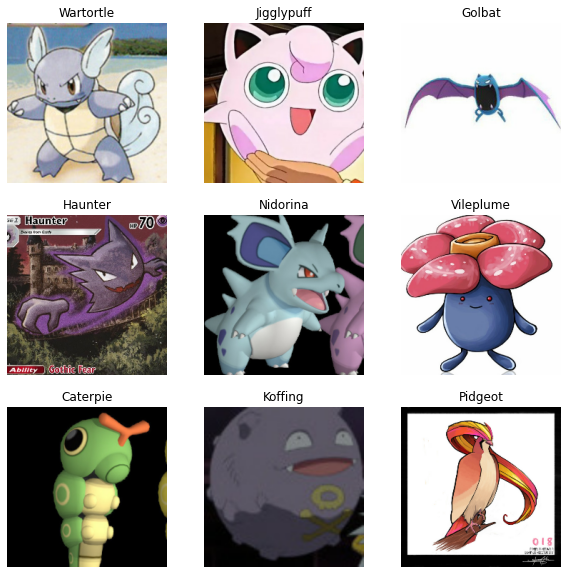

In [4]:
import matplotlib.pyplot as plt

class_labels = sample_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in sample_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

### Standardization and perturbation layer

In [5]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(ROT_RANGE),
    layers.RandomTranslation(TRANS_RANGE, TRANS_RANGE, fill_mode='nearest'),
    layers.RandomZoom(ZOOM_RANGE, ZOOM_RANGE, fill_mode='nearest'),
])

### Sample training images

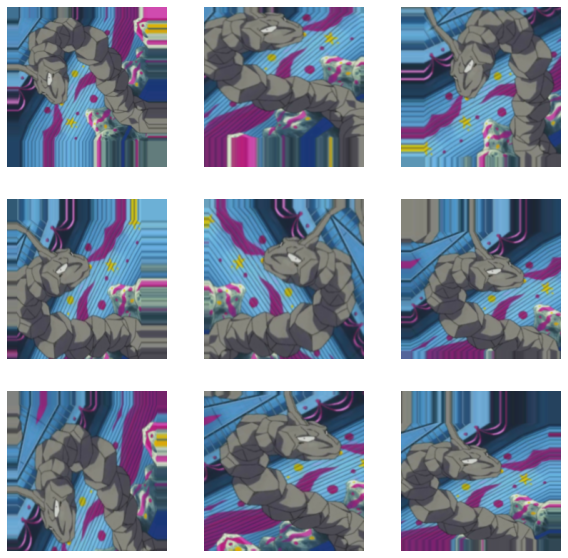

In [6]:
for image, _ in sample_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Preprocessing layer for base model

We will be using ResNet50 as our base model and thus need to use its preprocessing layer to properly format images.

In [7]:
from tensorflow.keras.applications import resnet_v2

preprocess_input = resnet_v2.preprocess_input

### Performance optimization

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## Model Definition

We will use ResNet50 as our base model with our own classification head. Softmax activation will be used to convert the output into probabilities for each label in the output layer

### Base ResNet50 instantiation

In [10]:
INPUT_DIM = IMAGE_SHAPE + (3,)
base_model = resnet_v2.ResNet50V2(input_shape=INPUT_DIM,include_top=False,weights='imagenet')

base_model.trainable = False

### Classification head

In [11]:
# Average pooling layer to flatten ResNet CNN output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Output layer
output_layer = layers.Dense(149,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))

### Building and compiling model

In [12]:
from tensorflow.keras.optimizers import Adam

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_PROP)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

## Training

To best balance training and overfitting, we will utilize keras's EarlyStopping callback to halt training once overfitting is detected by a decrease in validation accuracy. Checkpointing is used to save the model with the best validation performance to be later fine tuned, evaluated, and used as a classifier.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint("poke_model.h5",
                                                monitor="val_loss",
                                                save_best_only=True,
                                                mode="min")
early_stopping = EarlyStopping(monitor='val_loss',patience=3)

results = model.fit(train_dataset,
                    epochs=EPOCH_TRAIN,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, checkpoint],)

Epoch 1/30
183/183 [==============================] - 288s 1s/step - loss: 4.7254 - accuracy: 0.1331 - val_loss: 2.6320 - val_accuracy: 0.5111
Epoch 2/30
183/183 [==============================] - 275s 2s/step - loss: 2.9809 - accuracy: 0.3861 - val_loss: 1.9469 - val_accuracy: 0.6827
Epoch 3/30
183/183 [==============================] - 266s 1s/step - loss: 2.4583 - accuracy: 0.5103 - val_loss: 1.6673 - val_accuracy: 0.7581
Epoch 4/30
183/183 [==============================] - 244s 1s/step - loss: 2.2424 - accuracy: 0.5563 - val_loss: 1.5204 - val_accuracy: 0.7822
Epoch 5/30
183/183 [==============================] - 246s 1s/step - loss: 2.0901 - accuracy: 0.5959 - val_loss: 1.4242 - val_accuracy: 0.7822
Epoch 6/30
183/183 [==============================] - 247s 1s/step - loss: 1.9926 - accuracy: 0.6211 - val_loss: 1.3269 - val_accuracy: 0.8302
Epoch 7/30
183/183 [==============================] - 246s 1s/step - loss: 1.9126 - accuracy: 0.6425 - val_loss: 1.2721 - val_accuracy: 0.8388

### Training summary

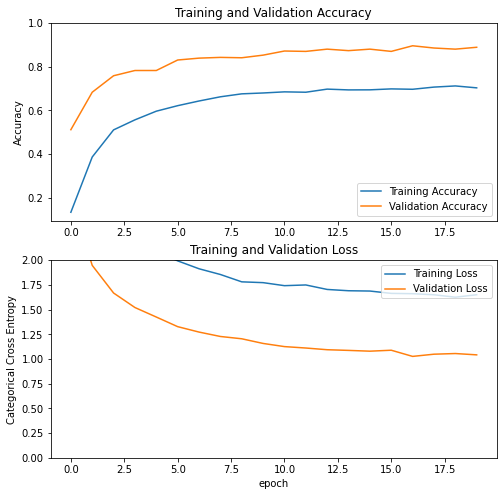

In [14]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

Train higher layers of the base model for this dataset for more performance

In [15]:
# Load best version
model = tf.keras.models.load_model('poke_model.h5')

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:(len(base_model.layers) - FINE_TUNE_LAYERS)]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE/50),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [16]:
fine_start = results.epoch[-1]

history_fine = model.fit(train_dataset,
                         epochs=EPOCH_TRAIN + EPOCH_FINE,
                         initial_epoch=results.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[early_stopping, checkpoint],)

model.save("Results/r50v2_2.h5")

Epoch 20/45
183/183 [==============================] - 254s 1s/step - loss: 1.5545 - accuracy: 0.7310 - val_loss: 1.0097 - val_accuracy: 0.9039
Epoch 21/45
183/183 [==============================] - 241s 1s/step - loss: 1.5185 - accuracy: 0.7467 - val_loss: 1.0028 - val_accuracy: 0.9091
Epoch 22/45
183/183 [==============================] - 244s 1s/step - loss: 1.5462 - accuracy: 0.7365 - val_loss: 0.9986 - val_accuracy: 0.9108
Epoch 23/45
183/183 [==============================] - 252s 1s/step - loss: 1.5241 - accuracy: 0.7451 - val_loss: 0.9977 - val_accuracy: 0.9160
Epoch 24/45
183/183 [==============================] - 252s 1s/step - loss: 1.5284 - accuracy: 0.7461 - val_loss: 0.9982 - val_accuracy: 0.9194
Epoch 25/45
183/183 [==============================] - 1050s 6s/step - loss: 1.5217 - accuracy: 0.7348 - val_loss: 1.0009 - val_accuracy: 0.9160
Epoch 26/45
183/183 [==============================] - 349s 2s/step - loss: 1.5378 - accuracy: 0.7448 - val_loss: 1.0013 - val_accuracy

### Fine tuning summary

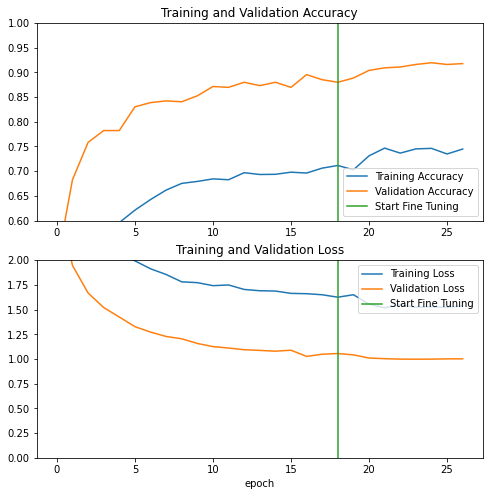

<Figure size 432x288 with 0 Axes>

In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([fine_start - 1,fine_start - 1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([fine_start - 1,fine_start - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('out.png')

## Final Evaluation

Evaluating performance on the testing dataset

In [18]:
test_dataset = image_dataset_from_directory(test_path,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMAGE_SHAPE,
                                            label_mode='categorical',
                                            labels='inferred',)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

model = tf.keras.models.load_model('Results/r50v2_2.h5')

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

Found 949 files belonging to 149 classes.
30/30 [==============================] - 17s 502ms/step - loss: 1.4299 - accuracy: 0.7850
Test accuracy : 0.7850368618965149


## Predictions

### Format printouts

In [19]:
sample_path = 'TestImages'
random_sample = True
encoding_path = 'one_hot_encoding.csv'
model_path = 'Results/r50v2_2.h5'

### Load model and image pool

In [20]:
import numpy as np
import os
import pandas as pd
from PIL import Image

data = pd.read_csv('pokemon.csv')
data = data[data['generation'] == 1]
lookup = pd.Index(data['name'])
encoding = pd.read_csv(encoding_path, index_col=0)

model = tf.keras.models.load_model(model_path)

sample_dataset = image_dataset_from_directory(sample_path, shuffle=random_sample, image_size=IMAGE_SHAPE, batch_size=1)

def get_stats(names):
    indexes = [lookup.get_loc(n) for n in names]
    print(('HP:\t\t', data['hp'][indexes[i]], '\t') for i in range(3))
    print(('Capture Rate:\t', data['capture_rate'][indexes[i]], '\t') for i in range(3))
    print(('Weight(kg):\t', data['weight_kg'][indexes[i]], '\t') for i in range(3))
    print(('Speed:\t\t', data['speed'][indexes[i]], '\t') for i in range(3))

Found 949 files belonging to 149 classes.


In [29]:
def run_on_image(sample, imagepath='TestImages'):
    # Get top 3 predictions with confidence
    output = model.predict(sample).flatten()
    print(output)
    top = np.argsort(-output)[:3]
    pred = [(encoding.name.iloc[t], output[t] * 100) for t in top]
    print(top)

    # Show input
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(2, 3, 2)
    for image, label in sample:
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title('Input Image')
        plt.axis("off")

    # Show results
    for i in range(3):
        ax = plt.subplot(2, 3, i + 4)
        imagesource = imagepath + '/' + pred[i][0]
        images = os.listdir(imagesource)
        r = int(np.random.rand() * len(images))
        img = Image.open(imagesource + '/' + images[r])
        plt.imshow(img)
        plt.title("{} - {:.2f}".format(pred[i][0], pred[i][1]))
        plt.axis("off")

    get_stats([p[0] for p in pred])
    

### Run on random image

1/1 [==============================] - 0s 88ms/step
[1.2504088e-08 1.7600435e-07 6.9942821e-08 6.1829333e-11 8.7532072e-08
 3.8546442e-09 9.6054600e-14 6.9018706e-13 5.0110567e-15 1.4906213e-11
 5.7396465e-13 2.0302361e-13 1.4386159e-12 5.9895319e-06 8.8656442e-09
 1.6228078e-07 1.2058178e-09 1.1289974e-12 4.0779355e-10 1.1620415e-07
 6.0298618e-08 6.5891281e-13 1.0198991e-10 1.6968330e-10 5.4927573e-11
 3.8974601e-11 3.5566990e-12 3.9151890e-13 4.3277142e-09 2.6158015e-12
 6.2244151e-12 3.4300773e-10 8.2325669e-10 4.7678207e-12 1.6176584e-12
 3.0786520e-13 2.0490358e-11 3.9925085e-09 6.3760202e-09 5.7814701e-11
 1.3111722e-08 4.1077716e-10 5.3498568e-13 4.8068497e-11 5.0670034e-11
 4.8018376e-07 7.3922153e-11 1.8658492e-08 3.3109508e-11 5.2738391e-10
 5.8565423e-11 4.0445073e-08 2.4886196e-11 7.7094544e-09 3.5831219e-10
 4.3979038e-09 4.7934301e-10 8.4341756e-15 2.3142759e-10 2.0096043e-10
 8.4789037e-11 1.4120505e-12 3.5656879e-07 2.3703199e-13 2.1797295e-13
 1.2544022e-09 6.0884228e

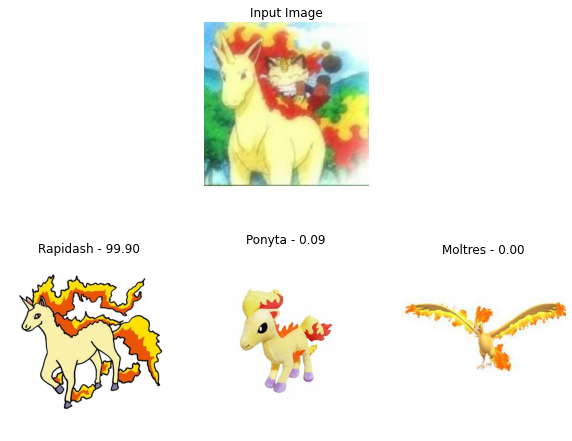

In [33]:
run_on_image(sample_dataset.take(1))